<a href="https://ibb.co/HT9vrgq"><img src="https://i.ibb.co/F4dvB7z/6-vs-3.png" alt="6-vs-3" border="0" width="700" height="600"></a>

This notebook is to check if only **3** channels can pull of **6** channels score [**CV:0.968 | LB:0.95**]. You can also check this [discussion](https://www.kaggle.com/c/seti-breakthrough-listen/discussion/238298) for more details. If this works we can take advantage of it. 
>Thus we can train using larger **batch_size** with larger **image_size** taking less **time** and with more **folds**.

If you find this ntoebok helpful Please Upvote.
This notebook is heavily based on this following two notebooks, please make sure you upvote them too,
* [SETI / NFNet_l0 starter [training]](https://www.kaggle.com/yasufuminakama/seti-nfnet-l0-starter-training)
* [SETI / NFNet_l0 starter [inference]](https://www.kaggle.com/yasufuminakama/seti-nfnet-l0-starter-inference)

# About this notebook
- PyTorch nfnet_l0 starter code
- StratifiedKFold 4 folds
- **3** channels instead of **6**

If this notebook is helpful, feel free to upvote :)

# Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
test = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "../input/seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "../input/seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,0000799a2b2c42d,0,../input/seti-breakthrough-listen/train/0/0000...
1,00042890562ff68,0,../input/seti-breakthrough-listen/train/0/0004...
2,0005364cdcb8e5b,0,../input/seti-breakthrough-listen/train/0/0005...
3,0007a5a46901c56,0,../input/seti-breakthrough-listen/train/0/0007...
4,0009283e145448e,0,../input/seti-breakthrough-listen/train/0/0009...


,id,target,file_path
0,000bf832cae9ff1,0.5,../input/seti-breakthrough-listen/test/0/000bf...
1,000c74cc71a1140,0.5,../input/seti-breakthrough-listen/test/0/000c7...
2,000f5f9851161d3,0.5,../input/seti-breakthrough-listen/test/0/000f5...
3,000f7499e95aba6,0.5,../input/seti-breakthrough-listen/test/0/000f7...
4,00133ce6ec257f9,0.5,../input/seti-breakthrough-listen/test/0/00133...


# Quick EDA

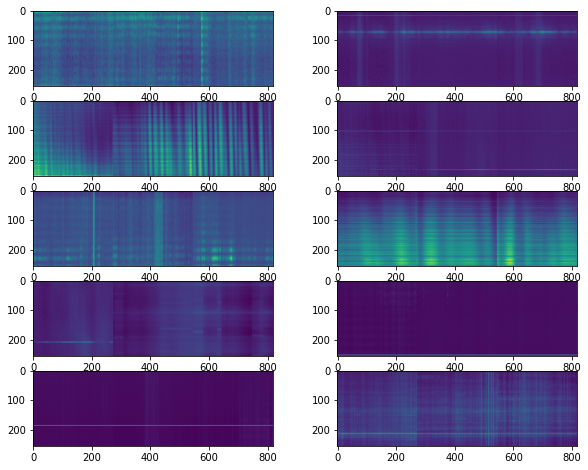

In [3]:
plt.figure(figsize=(10, 8))
for i in range(10):
    image = np.load(train.loc[i, 'file_path']) # (6, 273, 256)
    image = image[::2].astype(np.float32)
    image = np.vstack(image).transpose((1, 0)) # (1638, 256) -> (256, 1638)
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.show()

<AxesSubplot:>

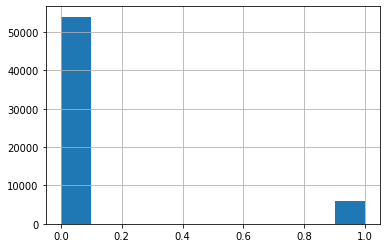

In [4]:
train['target'].hist()

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='nfnet_l0'
    size=224
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=6
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='target'
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [9]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         13500
      1          1500
1     0         13500
      1          1500
2     0         13500
      1          1500
3     0         13500
      1          1500
dtype: int64

# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.load(file_path)
        image = image[::2].astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [11]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            ToTensorV2(),
        ])

# MODEL

In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        self.n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

# Helper functions

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [14]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [15]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/nfnet_l0_ra2-45c6688d.pth" to /root/.cache/torch/hub/checkpoints/nfnet_l0_ra2-45c6688d.pth


Epoch: [1][0/703] Data 2.525 (2.525) Elapsed 0m 4s (remain 57m 9s) Loss: 0.7486(0.7486) Grad: 3.7939  
Epoch: [1][100/703] Data 0.000 (0.025) Elapsed 1m 29s (remain 8m 53s) Loss: 0.2863(0.3195) Grad: 1.1732  
Epoch: [1][200/703] Data 0.000 (0.013) Elapsed 2m 53s (remain 7m 13s) Loss: 0.2004(0.2898) Grad: 0.7562  
Epoch: [1][300/703] Data 0.000 (0.009) Elapsed 4m 17s (remain 5m 44s) Loss: 0.3238(0.2782) Grad: 0.4333  
Epoch: [1][400/703] Data 0.000 (0.006) Elapsed 5m 41s (remain 4m 17s) Loss: 0.3420(0.2743) Grad: 0.5945  
Epoch: [1][500/703] Data 0.000 (0.005) Elapsed 7m 6s (remain 2m 51s) Loss: 0.1388(0.2696) Grad: 1.5845  
Epoch: [1][600/703] Data 0.000 (0.004) Elapsed 8m 30s (remain 1m 26s) Loss: 0.1639(0.2649) Grad: 0.5945  
Epoch: [1][700/703] Data 0.000 (0.004) Elapsed 9m 55s (remain 0m 1s) Loss: 0.1821(0.2617) Grad: 0.9457  
Epoch: [1][702/703] Data 0.000 (0.004) Elapsed 9m 57s (remain 0m 0s) Loss: 0.1751(0.2613) Grad: 1.1253  
EVAL: [0/118] Data 3.648 (3.648) Elapsed 0m 3s (rema

Epoch 1 - avg_train_loss: 0.2613  avg_val_loss: 0.2310  time: 670s
Epoch 1 - Score: 0.7733
Epoch 1 - Save Best Score: 0.7733 Model


EVAL: [117/118] Data 0.000 (0.342) Elapsed 1m 12s (remain 0m 0s) Loss: 0.1122(0.2310) 


Epoch 1 - Save Best Loss: 0.2310 Model


Epoch: [2][0/703] Data 1.462 (1.462) Elapsed 0m 2s (remain 28m 28s) Loss: 0.1889(0.1889) Grad: 0.9876  
Epoch: [2][100/703] Data 0.000 (0.015) Elapsed 1m 27s (remain 8m 42s) Loss: 0.3066(0.2120) Grad: 1.0602  
Epoch: [2][200/703] Data 0.000 (0.007) Elapsed 2m 52s (remain 7m 9s) Loss: 0.1463(0.2173) Grad: 1.1151  
Epoch: [2][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 42s) Loss: 0.1893(0.2223) Grad: 0.5533  
Epoch: [2][400/703] Data 0.000 (0.004) Elapsed 5m 41s (remain 4m 16s) Loss: 0.2032(0.2237) Grad: 1.1686  
Epoch: [2][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.2169(0.2246) Grad: 0.6536  
Epoch: [2][600/703] Data 0.000 (0.003) Elapsed 8m 30s (remain 1m 26s) Loss: 0.1754(0.2234) Grad: 0.6935  
Epoch: [2][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.2220(0.2227) Grad: 0.4679  
Epoch: [2][702/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 0s) Loss: 0.1354(0.2224) Grad: 0.6104  
EVAL: [0/118] Data 3.797 (3.797) Elapsed 0m 4s (rema

Epoch 2 - avg_train_loss: 0.2224  avg_val_loss: 0.2235  time: 668s
Epoch 2 - Score: 0.7878
Epoch 2 - Save Best Score: 0.7878 Model


EVAL: [117/118] Data 0.000 (0.335) Elapsed 1m 11s (remain 0m 0s) Loss: 0.1230(0.2235) 


Epoch 2 - Save Best Loss: 0.2235 Model


Epoch: [3][0/703] Data 1.486 (1.486) Elapsed 0m 2s (remain 29m 3s) Loss: 0.2226(0.2226) Grad: 0.6923  
Epoch: [3][100/703] Data 0.000 (0.015) Elapsed 1m 26s (remain 8m 37s) Loss: 0.2023(0.1997) Grad: 1.3878  
Epoch: [3][200/703] Data 0.000 (0.008) Elapsed 2m 51s (remain 7m 8s) Loss: 0.1954(0.1927) Grad: 0.4809  
Epoch: [3][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 41s) Loss: 0.2609(0.1960) Grad: 0.8281  
Epoch: [3][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.2777(0.2001) Grad: 1.0849  
Epoch: [3][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.1022(0.2021) Grad: 0.6233  
Epoch: [3][600/703] Data 0.000 (0.003) Elapsed 8m 29s (remain 1m 26s) Loss: 0.2763(0.2033) Grad: 0.7452  
Epoch: [3][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.1045(0.2028) Grad: 1.0335  
Epoch: [3][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Loss: 0.3422(0.2029) Grad: 0.8566  
EVAL: [0/118] Data 3.660 (3.660) Elapsed 0m 3s (remai

Epoch 3 - avg_train_loss: 0.2029  avg_val_loss: 0.2236  time: 666s
Epoch 3 - Score: 0.7879
Epoch 3 - Save Best Score: 0.7879 Model


EVAL: [117/118] Data 0.000 (0.322) Elapsed 1m 9s (remain 0m 0s) Loss: 0.1241(0.2236) 
Epoch: [4][0/703] Data 1.407 (1.407) Elapsed 0m 2s (remain 26m 36s) Loss: 0.2208(0.2208) Grad: 0.9159  
Epoch: [4][100/703] Data 0.000 (0.014) Elapsed 1m 26s (remain 8m 37s) Loss: 0.0869(0.1780) Grad: 0.3320  
Epoch: [4][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 7s) Loss: 0.1460(0.1775) Grad: 0.7892  
Epoch: [4][300/703] Data 0.000 (0.005) Elapsed 4m 15s (remain 5m 41s) Loss: 0.1479(0.1730) Grad: 2.4135  
Epoch: [4][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.2449(0.1749) Grad: 1.3871  
Epoch: [4][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.1283(0.1762) Grad: 0.2935  
Epoch: [4][600/703] Data 0.000 (0.003) Elapsed 8m 29s (remain 1m 26s) Loss: 0.1424(0.1760) Grad: 0.7143  
Epoch: [4][700/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 1s) Loss: 0.0645(0.1744) Grad: 0.9779  
Epoch: [4][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Lo

Epoch 4 - avg_train_loss: 0.1743  avg_val_loss: 0.2267  time: 666s
Epoch 4 - Score: 0.7838


EVAL: [117/118] Data 0.000 (0.326) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1496(0.2267) 
Epoch: [5][0/703] Data 1.264 (1.264) Elapsed 0m 2s (remain 25m 41s) Loss: 0.1850(0.1850) Grad: 0.9466  
Epoch: [5][100/703] Data 0.000 (0.013) Elapsed 1m 26s (remain 8m 36s) Loss: 0.1147(0.1390) Grad: 1.8995  
Epoch: [5][200/703] Data 0.000 (0.006) Elapsed 2m 51s (remain 7m 7s) Loss: 0.0972(0.1365) Grad: 2.0345  
Epoch: [5][300/703] Data 0.000 (0.004) Elapsed 4m 15s (remain 5m 41s) Loss: 0.0833(0.1354) Grad: 0.4795  
Epoch: [5][400/703] Data 0.000 (0.003) Elapsed 5m 40s (remain 4m 16s) Loss: 0.1858(0.1369) Grad: 1.1682  
Epoch: [5][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.0817(0.1378) Grad: 1.2869  
Epoch: [5][600/703] Data 0.000 (0.002) Elapsed 8m 29s (remain 1m 26s) Loss: 0.0469(0.1380) Grad: 2.1471  
Epoch: [5][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.0726(0.1380) Grad: 0.3336  
Epoch: [5][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) L

Epoch 5 - avg_train_loss: 0.1380  avg_val_loss: 0.2580  time: 667s
Epoch 5 - Score: 0.7755


EVAL: [117/118] Data 0.000 (0.334) Elapsed 1m 11s (remain 0m 0s) Loss: 0.1308(0.2580) 
Epoch: [6][0/703] Data 1.231 (1.231) Elapsed 0m 2s (remain 26m 36s) Loss: 0.1542(0.1542) Grad: 2.0303  
Epoch: [6][100/703] Data 0.000 (0.012) Elapsed 1m 26s (remain 8m 37s) Loss: 0.0480(0.1061) Grad: 0.7472  
Epoch: [6][200/703] Data 0.000 (0.006) Elapsed 2m 51s (remain 7m 7s) Loss: 0.0934(0.1063) Grad: 0.8306  
Epoch: [6][300/703] Data 0.000 (0.004) Elapsed 4m 15s (remain 5m 41s) Loss: 0.0243(0.1033) Grad: 0.4459  
Epoch: [6][400/703] Data 0.000 (0.003) Elapsed 5m 40s (remain 4m 16s) Loss: 0.1988(0.1053) Grad: 2.6306  
Epoch: [6][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.0646(0.1046) Grad: 0.9292  
Epoch: [6][600/703] Data 0.000 (0.002) Elapsed 8m 28s (remain 1m 26s) Loss: 0.0386(0.1026) Grad: 1.8142  
Epoch: [6][700/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 1s) Loss: 0.0482(0.1035) Grad: 2.1701  
Epoch: [6][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) L

Epoch 6 - avg_train_loss: 0.1035  avg_val_loss: 0.3060  time: 666s
Epoch 6 - Score: 0.7724


EVAL: [117/118] Data 0.000 (0.327) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1136(0.3060) 


========== fold: 0 result ==========
Score: 0.7878
========== fold: 1 training ==========


Epoch: [1][0/703] Data 1.184 (1.184) Elapsed 0m 2s (remain 25m 54s) Loss: 0.7156(0.7156) Grad: 3.6300  
Epoch: [1][100/703] Data 0.000 (0.012) Elapsed 1m 25s (remain 8m 29s) Loss: 0.3738(0.3207) Grad: 0.4625  
Epoch: [1][200/703] Data 0.000 (0.006) Elapsed 2m 49s (remain 7m 2s) Loss: 0.3183(0.2926) Grad: 0.9552  
Epoch: [1][300/703] Data 0.000 (0.004) Elapsed 4m 13s (remain 5m 38s) Loss: 0.1863(0.2788) Grad: 0.9373  
Epoch: [1][400/703] Data 0.000 (0.003) Elapsed 5m 38s (remain 4m 14s) Loss: 0.1801(0.2683) Grad: 0.7886  
Epoch: [1][500/703] Data 0.000 (0.003) Elapsed 7m 2s (remain 2m 50s) Loss: 0.1856(0.2635) Grad: 0.5317  
Epoch: [1][600/703] Data 0.000 (0.002) Elapsed 8m 27s (remain 1m 26s) Loss: 0.3551(0.2587) Grad: 1.9293  
Epoch: [1][700/703] Data 0.000 (0.002) Elapsed 9m 51s (remain 0m 1s) Loss: 0.1393(0.2566) Grad: 0.5095  
Epoch: [1][702/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 0s) Loss: 0.4040(0.2566) Grad: 1.0182  
EVAL: [0/118] Data 3.747 (3.747) Elapsed 0m 4s (rema

Epoch 1 - avg_train_loss: 0.2566  avg_val_loss: 0.2357  time: 664s
Epoch 1 - Score: 0.7688
Epoch 1 - Save Best Score: 0.7688 Model


EVAL: [117/118] Data 0.000 (0.328) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1956(0.2357) 


Epoch 1 - Save Best Loss: 0.2357 Model


Epoch: [2][0/703] Data 1.388 (1.388) Elapsed 0m 2s (remain 26m 29s) Loss: 0.2053(0.2053) Grad: 0.6961  
Epoch: [2][100/703] Data 0.000 (0.014) Elapsed 1m 26s (remain 8m 37s) Loss: 0.1349(0.2243) Grad: 0.4528  
Epoch: [2][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 7s) Loss: 0.2806(0.2261) Grad: 0.6204  
Epoch: [2][300/703] Data 0.000 (0.005) Elapsed 4m 15s (remain 5m 41s) Loss: 0.2749(0.2227) Grad: 0.7875  
Epoch: [2][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.1728(0.2209) Grad: 0.9715  
Epoch: [2][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.2555(0.2238) Grad: 0.9712  
Epoch: [2][600/703] Data 0.000 (0.003) Elapsed 8m 28s (remain 1m 26s) Loss: 0.1547(0.2214) Grad: 0.8242  
Epoch: [2][700/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 1s) Loss: 0.1220(0.2204) Grad: 0.4807  
Epoch: [2][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Loss: 0.1803(0.2204) Grad: 0.9748  
EVAL: [0/118] Data 3.709 (3.709) Elapsed 0m 4s (rema

Epoch 2 - avg_train_loss: 0.2204  avg_val_loss: 0.2342  time: 665s
Epoch 2 - Score: 0.7777
Epoch 2 - Save Best Score: 0.7777 Model


EVAL: [117/118] Data 0.000 (0.318) Elapsed 1m 9s (remain 0m 0s) Loss: 0.2175(0.2342) 


Epoch 2 - Save Best Loss: 0.2342 Model


Epoch: [3][0/703] Data 1.211 (1.211) Elapsed 0m 2s (remain 25m 5s) Loss: 0.2514(0.2514) Grad: 0.6714  
Epoch: [3][100/703] Data 0.000 (0.012) Elapsed 1m 26s (remain 8m 37s) Loss: 0.1790(0.2069) Grad: 0.2097  
Epoch: [3][200/703] Data 0.000 (0.006) Elapsed 2m 51s (remain 7m 7s) Loss: 0.2713(0.2075) Grad: 1.2888  
Epoch: [3][300/703] Data 0.000 (0.004) Elapsed 4m 15s (remain 5m 41s) Loss: 0.2212(0.2106) Grad: 0.5569  
Epoch: [3][400/703] Data 0.000 (0.003) Elapsed 5m 40s (remain 4m 16s) Loss: 0.2691(0.2055) Grad: 0.5980  
Epoch: [3][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.1878(0.2038) Grad: 0.4131  
Epoch: [3][600/703] Data 0.000 (0.002) Elapsed 8m 30s (remain 1m 26s) Loss: 0.0547(0.2037) Grad: 0.7434  
Epoch: [3][700/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 1s) Loss: 0.2905(0.2029) Grad: 0.7888  
Epoch: [3][702/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 0s) Loss: 0.0966(0.2028) Grad: 0.8645  
EVAL: [0/118] Data 3.874 (3.874) Elapsed 0m 4s (remai

Epoch 3 - avg_train_loss: 0.2028  avg_val_loss: 0.2282  time: 668s
Epoch 3 - Score: 0.7844
Epoch 3 - Save Best Score: 0.7844 Model


EVAL: [117/118] Data 0.000 (0.323) Elapsed 1m 10s (remain 0m 0s) Loss: 0.1977(0.2282) 


Epoch 3 - Save Best Loss: 0.2282 Model


Epoch: [4][0/703] Data 1.316 (1.316) Elapsed 0m 2s (remain 25m 56s) Loss: 0.1159(0.1159) Grad: 1.2496  
Epoch: [4][100/703] Data 0.000 (0.013) Elapsed 1m 27s (remain 8m 40s) Loss: 0.1733(0.1775) Grad: 0.2770  
Epoch: [4][200/703] Data 0.000 (0.007) Elapsed 2m 52s (remain 7m 11s) Loss: 0.1886(0.1819) Grad: 1.2103  
Epoch: [4][300/703] Data 0.000 (0.005) Elapsed 4m 17s (remain 5m 43s) Loss: 0.3209(0.1802) Grad: 1.0036  
Epoch: [4][400/703] Data 0.000 (0.004) Elapsed 5m 42s (remain 4m 17s) Loss: 0.0720(0.1832) Grad: 1.6175  
Epoch: [4][500/703] Data 0.000 (0.003) Elapsed 7m 6s (remain 2m 52s) Loss: 0.2506(0.1813) Grad: 1.4430  
Epoch: [4][600/703] Data 0.000 (0.002) Elapsed 8m 31s (remain 1m 26s) Loss: 0.1144(0.1790) Grad: 0.7077  
Epoch: [4][700/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 1s) Loss: 0.0646(0.1781) Grad: 1.3134  
Epoch: [4][702/703] Data 0.000 (0.002) Elapsed 9m 58s (remain 0m 0s) Loss: 0.2230(0.1780) Grad: 0.9919  
EVAL: [0/118] Data 3.281 (3.281) Elapsed 0m 3s (rem

Epoch 4 - avg_train_loss: 0.1780  avg_val_loss: 0.2349  time: 669s
Epoch 4 - Score: 0.7811


EVAL: [117/118] Data 0.000 (0.316) Elapsed 1m 10s (remain 0m 0s) Loss: 0.2414(0.2349) 
Epoch: [5][0/703] Data 1.266 (1.266) Elapsed 0m 2s (remain 26m 23s) Loss: 0.0487(0.0487) Grad: 0.5755  
Epoch: [5][100/703] Data 0.000 (0.013) Elapsed 1m 27s (remain 8m 39s) Loss: 0.1188(0.1418) Grad: 0.6398  
Epoch: [5][200/703] Data 0.000 (0.007) Elapsed 2m 52s (remain 7m 10s) Loss: 0.1377(0.1407) Grad: 1.2297  
Epoch: [5][300/703] Data 0.000 (0.004) Elapsed 4m 17s (remain 5m 43s) Loss: 0.2765(0.1396) Grad: 1.2816  
Epoch: [5][400/703] Data 0.000 (0.003) Elapsed 5m 42s (remain 4m 17s) Loss: 0.1479(0.1413) Grad: 1.1111  
Epoch: [5][500/703] Data 0.000 (0.003) Elapsed 7m 7s (remain 2m 52s) Loss: 0.0986(0.1417) Grad: 0.9800  
Epoch: [5][600/703] Data 0.000 (0.002) Elapsed 8m 32s (remain 1m 26s) Loss: 0.1568(0.1399) Grad: 1.4473  
Epoch: [5][700/703] Data 0.000 (0.002) Elapsed 9m 57s (remain 0m 1s) Loss: 0.0704(0.1408) Grad: 2.3863  
Epoch: [5][702/703] Data 0.000 (0.002) Elapsed 9m 58s (remain 0m 0s) 

Epoch 5 - avg_train_loss: 0.1407  avg_val_loss: 0.2769  time: 671s
Epoch 5 - Score: 0.7748


EVAL: [117/118] Data 0.000 (0.341) Elapsed 1m 12s (remain 0m 0s) Loss: 0.2849(0.2769) 
Epoch: [6][0/703] Data 1.383 (1.383) Elapsed 0m 2s (remain 26m 40s) Loss: 0.2790(0.2790) Grad: 1.8666  
Epoch: [6][100/703] Data 0.000 (0.014) Elapsed 1m 27s (remain 8m 39s) Loss: 0.0683(0.1090) Grad: 1.1260  
Epoch: [6][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 9s) Loss: 0.0827(0.0992) Grad: 1.1000  
Epoch: [6][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 42s) Loss: 0.0463(0.0944) Grad: 1.5612  
Epoch: [6][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.0691(0.0942) Grad: 1.1611  
Epoch: [6][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.0946(0.0922) Grad: 1.9390  
Epoch: [6][600/703] Data 0.000 (0.003) Elapsed 8m 29s (remain 1m 26s) Loss: 0.0514(0.0909) Grad: 1.6874  
Epoch: [6][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.1373(0.0891) Grad: 2.8921  
Epoch: [6][702/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 0s) L

Epoch 6 - avg_train_loss: 0.0891  avg_val_loss: 0.3443  time: 667s
Epoch 6 - Score: 0.7525


EVAL: [117/118] Data 0.000 (0.333) Elapsed 1m 11s (remain 0m 0s) Loss: 0.3647(0.3443) 


========== fold: 1 result ==========
Score: 0.7844
========== fold: 2 training ==========


Epoch: [1][0/703] Data 1.089 (1.089) Elapsed 0m 1s (remain 23m 15s) Loss: 0.6689(0.6689) Grad: 2.5953  
Epoch: [1][100/703] Data 0.000 (0.011) Elapsed 1m 25s (remain 8m 28s) Loss: 0.2378(0.2722) Grad: 1.5321  
Epoch: [1][200/703] Data 0.000 (0.006) Elapsed 2m 49s (remain 7m 3s) Loss: 0.0559(0.2642) Grad: 0.8804  
Epoch: [1][300/703] Data 0.000 (0.004) Elapsed 4m 13s (remain 5m 39s) Loss: 0.2554(0.2640) Grad: 1.1519  
Epoch: [1][400/703] Data 0.000 (0.003) Elapsed 5m 38s (remain 4m 14s) Loss: 0.2812(0.2606) Grad: 0.8082  
Epoch: [1][500/703] Data 0.000 (0.002) Elapsed 7m 2s (remain 2m 50s) Loss: 0.3526(0.2554) Grad: 0.8210  
Epoch: [1][600/703] Data 0.000 (0.002) Elapsed 8m 27s (remain 1m 26s) Loss: 0.2538(0.2504) Grad: 0.8123  
Epoch: [1][700/703] Data 0.000 (0.002) Elapsed 9m 51s (remain 0m 1s) Loss: 0.2358(0.2501) Grad: 0.2855  
Epoch: [1][702/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 0s) Loss: 0.2876(0.2501) Grad: 0.9104  
EVAL: [0/118] Data 3.762 (3.762) Elapsed 0m 4s (rema

Epoch 1 - avg_train_loss: 0.2501  avg_val_loss: 0.2369  time: 665s
Epoch 1 - Score: 0.7714
Epoch 1 - Save Best Score: 0.7714 Model


EVAL: [117/118] Data 0.000 (0.338) Elapsed 1m 11s (remain 0m 0s) Loss: 0.0615(0.2369) 


Epoch 1 - Save Best Loss: 0.2369 Model


Epoch: [2][0/703] Data 1.413 (1.413) Elapsed 0m 2s (remain 27m 50s) Loss: 0.2859(0.2859) Grad: 0.7762  
Epoch: [2][100/703] Data 0.000 (0.014) Elapsed 1m 27s (remain 8m 39s) Loss: 0.2574(0.2199) Grad: 0.9363  
Epoch: [2][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 9s) Loss: 0.2066(0.2236) Grad: 0.8687  
Epoch: [2][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 42s) Loss: 0.1159(0.2174) Grad: 0.7315  
Epoch: [2][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.2224(0.2208) Grad: 1.2061  
Epoch: [2][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.1880(0.2184) Grad: 0.3838  
Epoch: [2][600/703] Data 0.000 (0.003) Elapsed 8m 29s (remain 1m 26s) Loss: 0.0900(0.2197) Grad: 1.1405  
Epoch: [2][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.2115(0.2202) Grad: 1.3703  
Epoch: [2][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Loss: 0.1066(0.2202) Grad: 0.7352  
EVAL: [0/118] Data 3.719 (3.719) Elapsed 0m 4s (rema

Epoch 2 - avg_train_loss: 0.2202  avg_val_loss: 0.2279  time: 667s
Epoch 2 - Score: 0.7857
Epoch 2 - Save Best Score: 0.7857 Model


EVAL: [117/118] Data 0.000 (0.328) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0696(0.2279) 


Epoch 2 - Save Best Loss: 0.2279 Model


Epoch: [3][0/703] Data 1.315 (1.315) Elapsed 0m 2s (remain 25m 27s) Loss: 0.1781(0.1781) Grad: 0.3158  
Epoch: [3][100/703] Data 0.000 (0.013) Elapsed 1m 27s (remain 8m 39s) Loss: 0.2469(0.1928) Grad: 0.9225  
Epoch: [3][200/703] Data 0.000 (0.007) Elapsed 2m 52s (remain 7m 10s) Loss: 0.2859(0.1934) Grad: 0.6332  
Epoch: [3][300/703] Data 0.000 (0.005) Elapsed 4m 17s (remain 5m 43s) Loss: 0.0492(0.1931) Grad: 0.5233  
Epoch: [3][400/703] Data 0.000 (0.003) Elapsed 5m 41s (remain 4m 17s) Loss: 0.2179(0.1957) Grad: 0.6942  
Epoch: [3][500/703] Data 0.000 (0.003) Elapsed 7m 6s (remain 2m 51s) Loss: 0.2270(0.1986) Grad: 1.3152  
Epoch: [3][600/703] Data 0.000 (0.002) Elapsed 8m 31s (remain 1m 26s) Loss: 0.1734(0.1995) Grad: 0.9596  
Epoch: [3][700/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 1s) Loss: 0.2604(0.2006) Grad: 1.2520  
Epoch: [3][702/703] Data 0.000 (0.002) Elapsed 9m 57s (remain 0m 0s) Loss: 0.2957(0.2007) Grad: 0.4784  
EVAL: [0/118] Data 3.992 (3.992) Elapsed 0m 4s (rem

Epoch 3 - avg_train_loss: 0.2007  avg_val_loss: 0.2238  time: 668s
Epoch 3 - Score: 0.7880
Epoch 3 - Save Best Score: 0.7880 Model


EVAL: [117/118] Data 0.000 (0.326) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0621(0.2238) 


Epoch 3 - Save Best Loss: 0.2238 Model


Epoch: [4][0/703] Data 1.252 (1.252) Elapsed 0m 2s (remain 25m 59s) Loss: 0.1294(0.1294) Grad: 0.5543  
Epoch: [4][100/703] Data 0.000 (0.013) Elapsed 1m 26s (remain 8m 37s) Loss: 0.1545(0.1750) Grad: 0.2257  
Epoch: [4][200/703] Data 0.000 (0.006) Elapsed 2m 51s (remain 7m 8s) Loss: 0.1401(0.1737) Grad: 1.0509  
Epoch: [4][300/703] Data 0.000 (0.004) Elapsed 4m 15s (remain 5m 41s) Loss: 0.1511(0.1757) Grad: 2.6054  
Epoch: [4][400/703] Data 0.000 (0.003) Elapsed 5m 40s (remain 4m 16s) Loss: 0.3283(0.1755) Grad: 4.5166  
Epoch: [4][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.2637(0.1742) Grad: 0.7668  
Epoch: [4][600/703] Data 0.000 (0.002) Elapsed 8m 29s (remain 1m 26s) Loss: 0.2036(0.1740) Grad: 1.2712  
Epoch: [4][700/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 1s) Loss: 0.1784(0.1743) Grad: 1.1682  
Epoch: [4][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Loss: 0.1784(0.1743) Grad: 0.5530  
EVAL: [0/118] Data 3.613 (3.613) Elapsed 0m 3s (rema

Epoch 4 - avg_train_loss: 0.1743  avg_val_loss: 0.2307  time: 665s
Epoch 4 - Score: 0.7861


EVAL: [117/118] Data 0.000 (0.311) Elapsed 1m 8s (remain 0m 0s) Loss: 0.0485(0.2307) 
Epoch: [5][0/703] Data 1.278 (1.278) Elapsed 0m 2s (remain 25m 46s) Loss: 0.2104(0.2104) Grad: 0.9022  
Epoch: [5][100/703] Data 0.000 (0.013) Elapsed 1m 26s (remain 8m 36s) Loss: 0.1358(0.1334) Grad: 0.5794  
Epoch: [5][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 7s) Loss: 0.1550(0.1383) Grad: 2.9880  
Epoch: [5][300/703] Data 0.000 (0.004) Elapsed 4m 15s (remain 5m 41s) Loss: 0.1750(0.1403) Grad: 0.8792  
Epoch: [5][400/703] Data 0.000 (0.003) Elapsed 5m 40s (remain 4m 16s) Loss: 0.1760(0.1406) Grad: 2.4888  
Epoch: [5][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.1138(0.1426) Grad: 2.3081  
Epoch: [5][600/703] Data 0.000 (0.002) Elapsed 8m 29s (remain 1m 26s) Loss: 0.1551(0.1411) Grad: 1.9614  
Epoch: [5][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.1706(0.1424) Grad: 0.7132  
Epoch: [5][702/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 0s) Lo

Epoch 5 - avg_train_loss: 0.1426  avg_val_loss: 0.2809  time: 667s
Epoch 5 - Score: 0.7756


EVAL: [117/118] Data 0.000 (0.320) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0452(0.2809) 
Epoch: [6][0/703] Data 1.344 (1.344) Elapsed 0m 2s (remain 25m 50s) Loss: 0.1024(0.1024) Grad: 0.6548  
Epoch: [6][100/703] Data 0.000 (0.014) Elapsed 1m 27s (remain 8m 40s) Loss: 0.1116(0.1253) Grad: 0.9992  
Epoch: [6][200/703] Data 0.000 (0.007) Elapsed 2m 52s (remain 7m 9s) Loss: 0.0695(0.1170) Grad: 0.4689  
Epoch: [6][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 42s) Loss: 0.1479(0.1142) Grad: 1.0143  
Epoch: [6][400/703] Data 0.000 (0.004) Elapsed 5m 41s (remain 4m 17s) Loss: 0.0790(0.1155) Grad: 1.1804  
Epoch: [6][500/703] Data 0.000 (0.003) Elapsed 7m 5s (remain 2m 51s) Loss: 0.0604(0.1130) Grad: 0.7429  
Epoch: [6][600/703] Data 0.000 (0.002) Elapsed 8m 30s (remain 1m 26s) Loss: 0.0482(0.1122) Grad: 2.0545  
Epoch: [6][700/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 1s) Loss: 0.0493(0.1110) Grad: 2.0024  
Epoch: [6][702/703] Data 0.000 (0.002) Elapsed 9m 57s (remain 0m 0s) L

Epoch 6 - avg_train_loss: 0.1110  avg_val_loss: 0.3327  time: 670s
Epoch 6 - Score: 0.7633


EVAL: [117/118] Data 0.000 (0.345) Elapsed 1m 12s (remain 0m 0s) Loss: 0.0345(0.3327) 


========== fold: 2 result ==========
Score: 0.7880
========== fold: 3 training ==========


Epoch: [1][0/703] Data 1.031 (1.031) Elapsed 0m 2s (remain 24m 18s) Loss: 0.6801(0.6801) Grad: 3.5592  
Epoch: [1][100/703] Data 0.000 (0.010) Elapsed 1m 25s (remain 8m 32s) Loss: 0.4181(0.3118) Grad: 0.9375  
Epoch: [1][200/703] Data 0.000 (0.005) Elapsed 2m 49s (remain 7m 4s) Loss: 0.2936(0.2896) Grad: 1.3456  
Epoch: [1][300/703] Data 0.000 (0.004) Elapsed 4m 14s (remain 5m 40s) Loss: 0.2615(0.2766) Grad: 0.8172  
Epoch: [1][400/703] Data 0.000 (0.003) Elapsed 5m 39s (remain 4m 15s) Loss: 0.2685(0.2703) Grad: 0.2999  
Epoch: [1][500/703] Data 0.000 (0.002) Elapsed 7m 4s (remain 2m 51s) Loss: 0.2655(0.2631) Grad: 0.7606  
Epoch: [1][600/703] Data 0.000 (0.002) Elapsed 8m 29s (remain 1m 26s) Loss: 0.2617(0.2590) Grad: 0.3332  
Epoch: [1][700/703] Data 0.000 (0.002) Elapsed 9m 53s (remain 0m 1s) Loss: 0.2972(0.2564) Grad: 0.3280  
Epoch: [1][702/703] Data 0.000 (0.002) Elapsed 9m 55s (remain 0m 0s) Loss: 0.1644(0.2562) Grad: 1.0610  
EVAL: [0/118] Data 2.833 (2.833) Elapsed 0m 3s (rema

Epoch 1 - avg_train_loss: 0.2562  avg_val_loss: 0.2346  time: 665s
Epoch 1 - Score: 0.7797
Epoch 1 - Save Best Score: 0.7797 Model


EVAL: [117/118] Data 0.000 (0.322) Elapsed 1m 9s (remain 0m 0s) Loss: 0.2645(0.2346) 


Epoch 1 - Save Best Loss: 0.2346 Model


Epoch: [2][0/703] Data 1.679 (1.679) Elapsed 0m 2s (remain 31m 54s) Loss: 0.2103(0.2103) Grad: 0.5481  
Epoch: [2][100/703] Data 0.000 (0.017) Elapsed 1m 27s (remain 8m 40s) Loss: 0.1913(0.2257) Grad: 1.0490  
Epoch: [2][200/703] Data 0.000 (0.009) Elapsed 2m 51s (remain 7m 9s) Loss: 0.3145(0.2290) Grad: 2.2349  
Epoch: [2][300/703] Data 0.000 (0.006) Elapsed 4m 16s (remain 5m 42s) Loss: 0.2479(0.2285) Grad: 1.3188  
Epoch: [2][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.2017(0.2252) Grad: 0.9122  
Epoch: [2][500/703] Data 0.000 (0.004) Elapsed 7m 5s (remain 2m 51s) Loss: 0.1433(0.2210) Grad: 0.8170  
Epoch: [2][600/703] Data 0.000 (0.003) Elapsed 8m 30s (remain 1m 26s) Loss: 0.1679(0.2216) Grad: 0.9455  
Epoch: [2][700/703] Data 0.000 (0.003) Elapsed 9m 54s (remain 0m 1s) Loss: 0.2500(0.2216) Grad: 0.8221  
Epoch: [2][702/703] Data 0.000 (0.003) Elapsed 9m 55s (remain 0m 0s) Loss: 0.1653(0.2218) Grad: 0.7993  
EVAL: [0/118] Data 3.979 (3.979) Elapsed 0m 4s (rema

Epoch 2 - avg_train_loss: 0.2218  avg_val_loss: 0.2216  time: 667s
Epoch 2 - Score: 0.7916
Epoch 2 - Save Best Score: 0.7916 Model


EVAL: [117/118] Data 0.000 (0.325) Elapsed 1m 11s (remain 0m 0s) Loss: 0.2310(0.2216) 


Epoch 2 - Save Best Loss: 0.2216 Model


Epoch: [3][0/703] Data 1.594 (1.594) Elapsed 0m 2s (remain 30m 44s) Loss: 0.1827(0.1827) Grad: 0.4456  
Epoch: [3][100/703] Data 0.000 (0.016) Elapsed 1m 26s (remain 8m 38s) Loss: 0.0622(0.1955) Grad: 1.6078  
Epoch: [3][200/703] Data 0.000 (0.008) Elapsed 2m 51s (remain 7m 7s) Loss: 0.2521(0.1944) Grad: 1.0901  
Epoch: [3][300/703] Data 0.000 (0.005) Elapsed 4m 14s (remain 5m 40s) Loss: 0.2767(0.1978) Grad: 1.3406  
Epoch: [3][400/703] Data 0.000 (0.004) Elapsed 5m 39s (remain 4m 15s) Loss: 0.2251(0.1969) Grad: 1.1353  
Epoch: [3][500/703] Data 0.000 (0.003) Elapsed 7m 3s (remain 2m 50s) Loss: 0.1328(0.1980) Grad: 0.2139  
Epoch: [3][600/703] Data 0.000 (0.003) Elapsed 8m 28s (remain 1m 26s) Loss: 0.3303(0.1991) Grad: 1.8297  
Epoch: [3][700/703] Data 0.000 (0.002) Elapsed 9m 52s (remain 0m 1s) Loss: 0.2353(0.1985) Grad: 0.9278  
Epoch: [3][702/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 0s) Loss: 0.1334(0.1984) Grad: 0.7983  
EVAL: [0/118] Data 3.863 (3.863) Elapsed 0m 4s (rema

Epoch 3 - avg_train_loss: 0.1984  avg_val_loss: 0.2286  time: 667s
Epoch 3 - Score: 0.7880


EVAL: [117/118] Data 0.000 (0.344) Elapsed 1m 12s (remain 0m 0s) Loss: 0.2521(0.2286) 
Epoch: [4][0/703] Data 1.392 (1.392) Elapsed 0m 2s (remain 26m 51s) Loss: 0.2354(0.2354) Grad: 1.1739  
Epoch: [4][100/703] Data 0.000 (0.014) Elapsed 1m 26s (remain 8m 38s) Loss: 0.1261(0.1691) Grad: 1.2958  
Epoch: [4][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 8s) Loss: 0.0810(0.1658) Grad: 0.3931  
Epoch: [4][300/703] Data 0.000 (0.005) Elapsed 4m 15s (remain 5m 41s) Loss: 0.1937(0.1702) Grad: 1.2361  
Epoch: [4][400/703] Data 0.000 (0.004) Elapsed 5m 40s (remain 4m 16s) Loss: 0.0911(0.1711) Grad: 1.2269  
Epoch: [4][500/703] Data 0.000 (0.003) Elapsed 7m 4s (remain 2m 51s) Loss: 0.1049(0.1700) Grad: 0.8928  
Epoch: [4][600/703] Data 0.000 (0.003) Elapsed 8m 29s (remain 1m 26s) Loss: 0.0930(0.1716) Grad: 0.6231  
Epoch: [4][700/703] Data 0.000 (0.002) Elapsed 9m 54s (remain 0m 1s) Loss: 0.1400(0.1697) Grad: 1.3095  
Epoch: [4][702/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 0s) L

Epoch 4 - avg_train_loss: 0.1698  avg_val_loss: 0.2415  time: 669s
Epoch 4 - Score: 0.7821


EVAL: [117/118] Data 0.000 (0.335) Elapsed 1m 12s (remain 0m 0s) Loss: 0.2357(0.2415) 
Epoch: [5][0/703] Data 1.364 (1.364) Elapsed 0m 2s (remain 26m 19s) Loss: 0.2158(0.2158) Grad: 0.6482  
Epoch: [5][100/703] Data 0.000 (0.014) Elapsed 1m 26s (remain 8m 37s) Loss: 0.0960(0.1384) Grad: 1.1045  
Epoch: [5][200/703] Data 0.000 (0.007) Elapsed 2m 51s (remain 7m 9s) Loss: 0.1311(0.1375) Grad: 0.5870  
Epoch: [5][300/703] Data 0.000 (0.005) Elapsed 4m 16s (remain 5m 43s) Loss: 0.1321(0.1387) Grad: 1.0562  
Epoch: [5][400/703] Data 0.000 (0.004) Elapsed 5m 41s (remain 4m 17s) Loss: 0.0945(0.1398) Grad: 0.6679  
Epoch: [5][500/703] Data 0.000 (0.003) Elapsed 7m 6s (remain 2m 52s) Loss: 0.1800(0.1381) Grad: 0.5915  
Epoch: [5][600/703] Data 0.000 (0.002) Elapsed 8m 31s (remain 1m 26s) Loss: 0.1468(0.1401) Grad: 1.2510  
Epoch: [5][700/703] Data 0.000 (0.002) Elapsed 9m 56s (remain 0m 1s) Loss: 0.2016(0.1392) Grad: 1.1983  
Epoch: [5][702/703] Data 0.000 (0.002) Elapsed 9m 58s (remain 0m 0s) L

Epoch 5 - avg_train_loss: 0.1391  avg_val_loss: 0.2516  time: 673s
Epoch 5 - Score: 0.7755


EVAL: [117/118] Data 0.000 (0.358) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2662(0.2516) 
Epoch: [6][0/703] Data 1.472 (1.472) Elapsed 0m 2s (remain 28m 20s) Loss: 0.0962(0.0962) Grad: 0.4664  
Epoch: [6][100/703] Data 0.000 (0.015) Elapsed 1m 27s (remain 8m 41s) Loss: 0.2058(0.1185) Grad: 1.5020  
Epoch: [6][200/703] Data 0.000 (0.008) Elapsed 2m 52s (remain 7m 9s) Loss: 0.2472(0.1081) Grad: 2.2820  
Epoch: [6][300/703] Data 0.000 (0.005) Elapsed 4m 17s (remain 5m 43s) Loss: 0.0291(0.1042) Grad: 0.6216  
Epoch: [6][400/703] Data 0.000 (0.004) Elapsed 5m 42s (remain 4m 17s) Loss: 0.2217(0.1035) Grad: 1.3312  
Epoch: [6][500/703] Data 0.000 (0.003) Elapsed 7m 7s (remain 2m 52s) Loss: 0.1543(0.1069) Grad: 1.3501  
Epoch: [6][600/703] Data 0.000 (0.003) Elapsed 8m 32s (remain 1m 26s) Loss: 0.0700(0.1059) Grad: 0.8415  
Epoch: [6][700/703] Data 0.000 (0.002) Elapsed 9m 57s (remain 0m 1s) Loss: 0.1399(0.1057) Grad: 1.5776  
Epoch: [6][702/703] Data 0.000 (0.002) Elapsed 9m 58s (remain 0m 0s) L

Epoch 6 - avg_train_loss: 0.1058  avg_val_loss: 0.2921  time: 674s
Epoch 6 - Score: 0.7707


EVAL: [117/118] Data 0.000 (0.362) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2236(0.2921) 


========== fold: 3 result ==========
Score: 0.7916
========== CV ==========
Score: 0.7825


# Inference

In [17]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.load(file_path)
        image = image[::2].astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        return image

In [18]:
# ====================================================
# Helper functions
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [19]:
# ====================================================
# inference
# ====================================================
model = CustomModel(CFG, pretrained=False)
MODEL_DIR = '/kaggle/working/'
states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)

  0%|          | 0/625 [00:00<?, ?it/s]

In [20]:
# submission
test['target'] = predictions
test[['id', 'target']].to_csv('submission.csv', index=False)
test[['id', 'target']].head()

,id,target
0,000bf832cae9ff1,0.088725
1,000c74cc71a1140,0.068858
2,000f5f9851161d3,0.069743
3,000f7499e95aba6,0.096652
4,00133ce6ec257f9,0.059953


<AxesSubplot:>

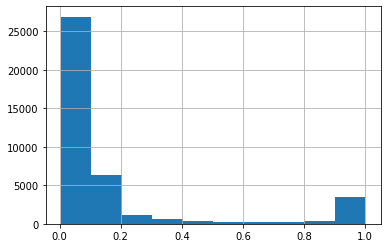

In [21]:
test['target'].hist()